# Study of Paris metro network 

<div style="background-color:#f7f7f7; padding:0.8em; border-radius:3px;">
    Mihali Kristi<br/>
    Vertaure Jordan
</div>

<div style="border-left:4px solid #41a4f5; padding-left:50px;">
<h2 id="Table-des-matières">Table of Contents<a class="anchor-link" href="#Table-des-matières">¶</a></h2><ul>
<li><a href="#Study-of-metro-stations">Study of metro stations</a><ul>
<li><a href="#Introduction">Introduction</a></li>
<li><a href="#I.-Data-formatting">I. Data formatting</a><ul>
<li>Loading libraries</li>
<li>Loading station information</li>
<li>Useful functions for merging</li>
<li>Loading lines and creating links</li>
</ul>
</li>
<li><a href="#II.-First-representation-of-the-graph">II. First representation of the graph</a><ul>
<li>Simple properties</li>
</ul>
</li>
<li><a href="#III.-First-Analysis">III. First Analysis</a><ul>
<li>Graph Erdös Rényi (Gnp)</li>
<li>Summary of the analysis</li>
</ul>
</li>
<li><a href="#IV.-Improved-visual-representation">IV. Improved visual representation</a><ul>
<li>Representation with the real positions of the nodes</li>
<li>Representation with line colors</li>
</ul>
</li>
<li><a href="#V.-Another representation of the graph">V. Another representation of the graph</a></li>
<li><a href="#VI.-Centrality analysis">VI. Centrality analysis</a></li>
<li><a href="#VII.-Conclusions">VII. Conclusions</a></li>
<li><a href="#References">References</a></li>

</ul>
</li>
</ul>
</div>

## Introduction

+ Data 1 : [Gares et stations trouvable](https://data.iledefrance.fr/explore/dataset/gares-et-stations-du-reseau-ferre-dile-de-france-donnee-generalisee/table/) to know the names of the stations.

+ Data 2 : [Tracé des lignes](https://data.iledefrance-mobilites.fr/explore/dataset/traces-du-reseau-ferre-idf/information/) to know the link between the stations.

+ Data 3 : [Traffic entrant des stations](https://data.iledefrance.fr/explore/dataset/trafic-annuel-entrant-par-station-du-reseau-ferre-2015/export/) to know the real importance of the stations.

+ Data 4 : [Couleur des lignes de métro](https://fr.wikipedia.org/wiki/Mod%C3%A8le:M%C3%A9tro_de_Paris/couleur_fond) to draw the lines with the official colours.


We retrieved a document containing the station data.


In the following document, it's possible to find information about the Metro System of the city of Paris. Focusing only on the metro stations and the connection between them, a potentially connected graph is going to be formed, representing the city's interconnection between the metro lines. 
With the extra information provided in the documents attached, we have the possibility to do a detailed analyze of the graph. 

From the documents attached, we were able to take the information needed, which are the nodes, representing the stations of each metro. The connection between them is specified in the second document, making it possible to create a potentially connected undirected tree. Each connection is going to have a weight attached to it, representing a good approximation distance between two stations. 
The detailed Geo Shape information provided in the documents permits to take into consideration the real position of the station, in order to have a specific representation of the nodes in the graph.

Filter: only the data of the points found in document 1 are used

Link: the minimum distance between a point in DOC2 and one of the points on the DOC1 lines is calculated.

## I. Data formatting
### Loading libraries

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import csv
import json
from math import *
import pandas as pd

### Chargement des informations de stations

In the first document, we are able to find the geographical coordinates of each station in the graph and also their names. This information is being read from the '.csv' files provided. <br> The coordinates are taken from the second column of the file and saved into the <b>'stations_to_id'</b> dictionary. Each station has a unique ID, which is being refered to onto the next dictionary, <b>'id_to_label'</b>, where the names of the stations are saved. <br>Another dictionary, <b>'label_to_id'</b>, where the key value will be the name of the station itself, is needed for further analysis.

In [2]:
objectID_to_id = {} # gives an id to each objectID id
# gives an id for each station
# key: (x, y)
# value: id
stations_to_id = {}
# id is the link between (x, y), objectID, label, xy... 
id_to_label = {}
label_to_id = {}
id_to_xy = {}

next_id = 0
stations_table = pd.read_csv('./data/Projet/gares-et-stations-du-reseau-ferre-dile-de-france-donnee-generalisee.csv', delimiter=';', quotechar='"')
for index, row in stations_table.iterrows():
    # Filters on Metro lines
    if 'Metro' not in row['mode_']:
        continue

    geo_shape = json.loads(row['Geo Shape'])
    x, y = geo_shape['coordinates']     
    objectID = row['OBJECTID']

    if objectID in objectID_to_id:
        id = objectID_to_id[objectID]
    else:
        id = next_id
        next_id += 1
        objectID_to_id[objectID] = id

    stations_to_id[(x, y)] = id
    id_to_label[id] = row['nom_long']
    label_to_id[row['nom_long']] = id
    id_to_xy[id] = (x, y)

In [3]:
stations_table.head()

,Geo Point,Geo Shape,OBJECTID,id_ref_zdl,nom_long,label,idrefliga,idrefligc,res_com,mode_,...,terrer,termetro,tertram,ternavette,terval,exploitant,principal,idf,x,y
0,"48.8677997345,2.31388193768","{""type"": ""Point"", ""coordinates"": [2.3138819376...",10,42531,CHAMPS-ELYSEES-CLEMENCEAU,Champs-Elysées-Clémenceau,A01534 / A01546,C01371 / C01383,M1 / M13,Metro,...,0,0,0,0,0,RATP,0,1,649668.4044,6.863304e+06
1,"48.8847082013,2.26051507789","{""type"": ""Point"", ""coordinates"": [2.2605150778...",14,44479,PONT DE NEUILLY (AVENUE DE MADRID),Pont de Neuilly,A01534,C01371,M1,Metro,...,0,0,0,0,0,RATP,0,1,645771.2870,6.865220e+06
2,"48.8515102782,2.39830234427","{""type"": ""Point"", ""coordinates"": [2.3983023442...",16,42271,AVRON,Avron,A01535,C01372,M2,Metro,...,0,0,0,0,0,RATP,0,1,655847.3058,6.861443e+06
3,"48.9078125468,2.45435282652","{""type"": ""Point"", ""coordinates"": [2.4543528265...",24,47334,JEAN ROSTAND,Jean Rostand,A01191,C01389,T1,Tramway,...,0,0,0,0,0,RATP,0,1,660003.4947,6.867673e+06
4,"48.9096663654,2.43748780358","{""type"": ""Point"", ""coordinates"": [2.4374878035...",26,52382,LA FERME,La Ferme,A01191,C01389,T1,Tramway,...,0,0,0,0,0,RATP,0,1,658768.7601,6.867888e+06


### Useful functions for merging

The next two functions are used to find the nearest station's ID from a specific coordinate (<b>nearest_id</b>) and finding the ID of a given point's coordinate (<b>id_from_xy</b>). 

In [4]:
# key: (x, y)
# value: id
trace_to_id = {}

# Returns the nearest station's id
def nearest_id(x, y):
    min_id = None
    min_dist = None
    for coord, id in stations_to_id.items():
        x_b = coord[0]
        y_b = coord[1]
        dist = sqrt( (x-x_b)**2 + (y-y_b)**2 )
        if min_dist is None or dist < min_dist:
            min_dist = dist
            min_id = id
    return min_id

# Returns the station id that should correspond to the coordinates
def id_from_xy(x, y):
    if (x, y) in trace_to_id:
        return trace_to_id[(x, y)]

    if (x, y) in stations_to_id:
        id = stations_to_id[(x, y)]
    else:
        id = nearest_id(x, y)

    trace_to_id[(x, y)] = id
        
    return id


### Loading lines and creating links

In order to make the connections between the nodes that we just uploaded, we need to read the "Traces" file. The <b>links</b> list is going to keep track of such details, appending coordinates of each node that have a connection between them. Since the <b>Geo Shape</b> column on the given '.csv' file holds the coordinates needed,
we are going to be taking from it the first and the last point, which represent the coordinates of the stations, building a link between the two of them. <br> Each station belongs to a metro line, specified in the <b>'indice_lig'</b> column of the '.csv' file. This way, we are able to keep track of Metro lines and the correspondance stations between them. This information is saved in <b>'line_too_links'</b> dictionary.


#### why keep track of links_weight when it's not used in further analysis

In [5]:
links = []
links_weight = []
line_to_links = {}

traces_table = pd.read_csv('./data/Projet/traces-du-reseau-ferre-idf.csv', delimiter=';', quotechar='"')
for line_index, row in traces_table.iterrows():
    # Filters on Metro lines
    if 'Metro' not in row['mode_']:
        continue
    geo_shape = json.loads(row['Geo Shape'])
    # Gathers a pair of nodes to link
    coord_1 = geo_shape['coordinates'][0]
    coord_2 = geo_shape['coordinates'][len(geo_shape['coordinates']) - 1]
    id_1 = id_from_xy(coord_1[0], coord_1[1])
    id_2 = id_from_xy(coord_2[0], coord_2[1])

    links.append((id_1, id_2))
    if not row['indice_lig'] in line_to_links:
        line_to_links[row['indice_lig']] = []
    line_to_links[row['indice_lig']].append((id_1, id_2))

    edge_length = 0
    for index in range(len(geo_shape['coordinates'])-2):
        x_1, y_1 = geo_shape['coordinates'][index]
        x_2, y_2 = geo_shape['coordinates'][index+1]
        edge_length += sqrt( (x_1-x_2)**2 + (y_1-y_2)**2 )
    links_weight.append(edge_length)

In [6]:
traces_table.head()

,Geo Point,Geo Shape,OBJECTID,idrefliga,idrefligc,indice_lig,res_com,reseau,mode_,fer,train,rer,metro,tramway,navette,val,idf,extcode,SHAPE_Leng,id_fmt_tem
0,"48.9048411435,2.51412270739","{""type"": ""LineString"", ""coordinates"": [[2.5116...",6,A01761,C01843,4,T4,TRAMWAY,Tramway,0,0,0,0,1,0,0,1,800:T4,642.624201,453 - T4 - 320
1,"48.7847677911,2.29528654547","{""type"": ""LineString"", ""coordinates"": [[2.2924...",13,A01857,C01743,B,RER B,RER B,RER,1,0,1,0,0,0,0,1,810:B,888.100684,790 - RER B - 287
2,"48.6415631156,2.44386902733","{""type"": ""LineString"", ""coordinates"": [[2.4522...",16,A01842,C01728,D,RER D,RER D,RER,1,0,1,0,0,0,0,1,800:D,1998.500570,334 - RER D - 276
3,"48.8465126271,2.22205382589","{""type"": ""LineString"", ""coordinates"": [[2.2218...",24,A01192,C01390,2,T2,TRAMWAY,Tramway,0,0,0,0,1,0,0,1,100112012:T2,762.278308,623 - T2 - 461
4,"48.6971698824,2.14414968575","{""type"": ""LineString"", ""coordinates"": [[2.1365...",27,A01857,C01743,B,RER B,RER B,RER,1,0,1,0,0,0,0,1,810:B,1177.983616,401 - RER B - 330


On the other '.csv' document provided, we have the traffic for each station on 2015. For each station, refered to with its ID saved in prior steps, we save the traffic on <b>'id_to_traffic'</b> dictionary.

In [7]:
id_to_traffic = {}
traffic_table = pd.read_csv('./data/Projet/trafic-annuel-entrant-par-station-du-reseau-ferre-2015.csv', delimiter=';',encoding = "ISO-8859-1")
for line_index, row in traffic_table.iterrows():
    if row['Reseau'] != 'Metro':
            continue
    station_name = row['Station']
    station_traffic = float(row['Trafic'])
    # Certaines noms de stations présentes dans le fichier de traffic ne correspondent pas aux noms du fichier des stations
    # Nous avons choisi de réparer les noms dont la correspondance est évidente et de ne pas traiter les autres
    # Très peu de stations sont concernées par ce cas.
    if station_name in label_to_id:
        id = label_to_id[station_name]
        id_to_traffic[id] = station_traffic

In [8]:
traffic_table.head()

,Rang,Reseau,Station,Trafic,Correspondance_1,Correspondance_2,Correspondance_3,Correspondance_4,Correspondance_5,Ville,Arrondissement pour Paris
0,17,Metro,ESPLANADE DE LA DEFENSE,10280556,1,NaN,NaN,NaN,NaN,Puteaux,NaN
1,101,Metro,GUY MOQUET,4577860,13,NaN,NaN,NaN,NaN,Paris,17.0
2,151,Metro,SENTIER,3509454,3,NaN,NaN,NaN,NaN,Paris,3.0
3,207,Metro,LIBERTE,2581261,8,NaN,NaN,NaN,NaN,Charenton,NaN
4,240,Metro,SAINT-JACQUES,2112450,6,NaN,NaN,NaN,NaN,Paris,13.0


## II. First representation of the graph

We've choosen to start representing the graph with a random layout in order to study it in without visual biais.

/Users/user/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


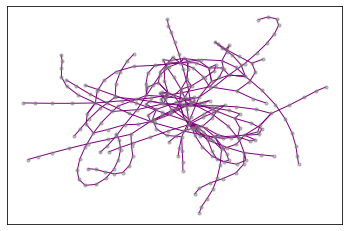

In [9]:
G = nx.Graph()
G.add_edges_from(links)
pos = nx.spring_layout(G)

colors = range(len(links))
nx.draw_networkx_nodes(G, pos, node_size=10, with_labels=True, node_color='grey', alpha=0.5)
nx.draw_networkx_edges(G, pos, edgelist=links, edge_color='purple')

### Simple properties

In this chapter we'll study the basic properties of our graph without much comments. We'll develop the analysis in a second part.

**Connection**<br>
In a logical point of view, a station cannot exist if it's not part of a metro line.<br> Trying to prove this hypothesis right, python provides us with a function. If the graph that we just uploaded, has at least a station that in not connected to none of the metro lines, it's considered to be not connected. Elsewise, the graph is considered connected.

In [10]:
if nx.is_connected(G):
    print('Le graph est connecté')
else:
    print('Le graph est non-connecté')

Le graph est connecté


The graphs is connected, meaning that no existing station is left out of a line metro.

**Number of nodes and links**

Such information is needed to be taken into consideration to know the complexity of the graph that we are working with.<br>
Metro lines have corresponding stations, which translates to having more lines that nodes. However, the difference between the two of them, should not be high. The number of corresponding stations is nearly insignificant compared to overall number of stations.

In [11]:
nb_nodes = G.number_of_nodes()
nb_edges = G.number_of_edges()
print(f"Nombre de noeuds : {nb_nodes}")
print(f"Nombre de liens : {nb_edges}")

Nombre de noeuds : 302
Nombre de liens : 370


**Diameter**

The longest path to go from a node to another is relatively long. 

In [12]:
diameter = nx.diameter(G)
print(f"Le diamètre du graph est : {diameter}")

Le diamètre du graph est : 35


**Average of the shortest paths**

The **average_shortest_path_length** gives a good indication on how the graph is built. A small result would indicate a structure with important hubs or a presence of connexions specially designed to link nodes that were previously far from each others. A large one would indicate the presence of long branches.

In [13]:
average_shortest_path_length = nx.average_shortest_path_length(G)
print(f"Moyenne des plus courts chemins : {average_shortest_path_length}")

Moyenne des plus courts chemins : 12.217068931376648


**Clustering coefficient**

The overall clustering coefficient is small, reassuring the lack of correspondance nodes. 

In [14]:
nx.average_clustering(G)

0.020766319772942292

**Distribution of degrees**

In the histogram showed below, it is clear that the dominante degree is 2, describes for another time, the dominance of stations that are not corresponding ones. Another way to say it is : the majority of the stations are a link between two stations.

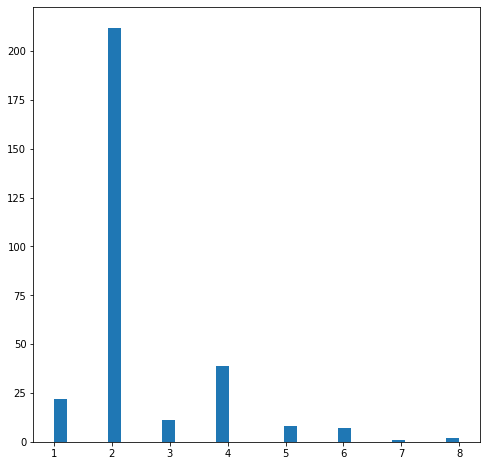

In [15]:
degree_sequence = [d for n, d in G.degree()]
plt.figure(figsize=(8,8))
plt.hist(degree_sequence, 30);

**Distribution des degrés (échelle log ; log)**

Text(0, 0.5, 'histogram')

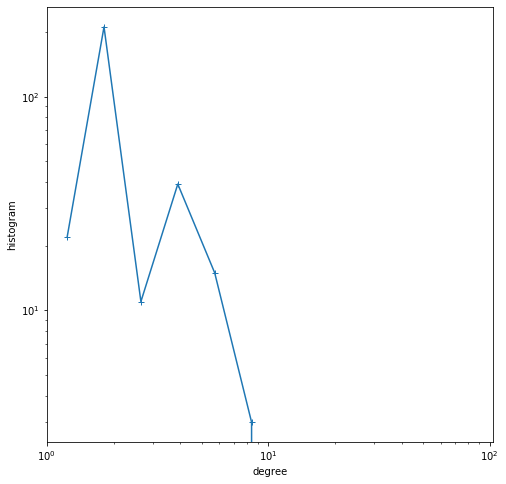

In [16]:
np.log10(2*np.max(degree_sequence))
bins = np.logspace(0,2, num =13)
x, y = np.histogram(degree_sequence, bins)
plt.figure(figsize=(8,8))
plt.loglog((y[1:]+y[:-1])/2, x, '+-')
plt.xlabel('degree')
plt.ylabel('histogram')

## III. First Analysis

For this first analysis we will ask ourselves a simple question :

<div style="font-size:1.5em; margin:35px 0 35px 0; color:black;font-family:verdana">Does the graph of the Parisian metro have the classic properties of complex graphs?</div>

**Sparsity**

In [70]:
n = nb_nodes
m = nb_edges
m_max = n*(n-1)*0.5
print(f"nombre de noeuds  : n = {n}")
print(f"nombre de connexions : m = {m}")
print(f"nombre de connexion maximales : m_max = {m_max}")

nombre de noeuds  : n = 302
nombre de connexions : m = 370
nombre de connexion maximales : m_max = 45451.0


We can observe that the number of nodes is of the same magnitude as the number : n = &thetasym;(m)<br/>
The maximal number of connections is much higher that the actual one : m_max >> n<br/>
As a result : our graph is **sparse**

In order to analye the properties we've gather above, we'll compare them to an interesting graph with known properties.

### Graph Erdös Rényi (Gnp)

**Construction of graph**

We build an Erdös Rényi graph with the same number of nodes (n).<br/>
We set the link probability p so that the resulting graph has a high chance of being connected :
$$p=\frac{log(n)}{n}$$
We generate a new graph until the generated one is connected.

In [18]:
n = nb_nodes
ER=nx.gnp_random_graph(n=n,p=(log(n)/n))
while not nx.is_connected(ER):
    ER=nx.gnp_random_graph(n=n,p=(log(n)/n))

We can notice that our choice for the value of p will create a graph with much more connexions than ours but it is necessary to generate a connected graph. For the same reason, the idea of using a chung-li graph as a model is not accurate in our case.

**Diameter and small world property**

In [19]:
ERDiameter = nx.diameter(ER)
print(f"Diametre du graph Erdös Rényi : {ERDiameter}")

Diametre du graph Erdös Rényi : 6


The diameter of our graph is much larger than an ER graph of the same size: 32>>>7.<br/>
We can conclude that **our graph is not a small world**.

**Average of the shortest paths**

In [20]:
print(f"Average Shorterst Path on ER: {nx.average_shortest_path_length(ER)}")

Average Shorterst Path on ER: 3.445886779168775


The average of the shortest paths of our graph is significantly higher than that of the ER graph : 10.9 >> 3.5.<br> 

The latest analysis holds an interesting value, because it shows that the logic on which the graph has been built (having the minimal number of connections between nodes) differs drastically in our case. Having this little connections between the nodes of the graph, affects the Shortest Path and many ither elements.

**Distribution des données**

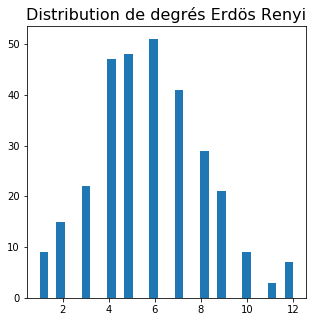

In [21]:
degree_sequence = [d for n, d in ER.degree()]
plt.figure(figsize=(5,5))
plt.title('Distribution de degrés Erdös Renyi', fontsize=16)
plt.hist(degree_sequence, 30);

**The distribution of degrees** of our graph is **heterogeneous**.<br/>
The ER graph provides an example of an homegeneous distribution.

The degree of a ER graph is sparse and random, meaning that it does not have a higher concentration on a specific number; meanwhile on our graph, the nodes that have a connection with only another node is strictly higher than others.

**Coefficient of medium clustering**

In [22]:
nx.average_clustering(ER)

0.01749376451363206

The average clustering coefficient of our graph is of the same order of magnitude as the ER : 0.047 = &thetasym;(0.015)<br/>
We can therefore say that our graph has a **low average clustering coefficient**

<div style="border:3px solid #41a4f5; margin:10px; padding:10px">
   

<h3 id="Summary-of-the-analysis">Summary of the analysis<a class="anchor-link" href="#Résumé-de-l'analyse">¶</a></h3>
<p>Our graph:</p>
<ul>
<li><input checked="" disabled="" type="checkbox"> is connected</li>
<li><input checked="" disabled="" type="checkbox"> is sparse</li>
<li><input disabled="" type="checkbox"> is not small world</li>
<li><input checked="" disabled="" type="checkbox"> has a heterogeneous degree distribution</li>
<li><input disabled="" type="checkbox"> has a low average clustering coefficient</li>
</ul>
<p>The metro network has therefore not <strong>not all the usual characteristics of complex graphs</strong>.
<br> An ER connected graph, with the same number of nodes, is showed to be quite more dense than our graph. This detail, makes the ER graph a complex graph; having more edges means that the graph has a higher possibility to be a small world and to have a higher clustering coefficient. <br> 
The actual number of edges in our graph is quite low, raising the diameter of the graph and lowering the clustering coefficient.  </p>
</div>

## IV. Improved visual representation
### Representation with the real positions of the nodes

Now that we have studied our graph without considering the spatialization it is time to consider it ! The reason our graph is so différent from the average complex graphs is certainly related to the spatialization as we'll prove it below.

Taking all the information from above, we are able to make a first representation of the graph, which is going to have the stations saved at <b>'id_to_xy'</b> as nodes, providing a realistic placement of the stations in the graph. The links are taken from <b>'links'</b>, creating a metro system.

> Notice that even if the nodes respects the real positions, the edges are simple lines. We got the information to make more realistic edges but the difference is not interesting and it complicates everything.

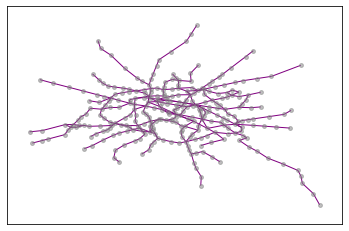

In [23]:
G = nx.Graph()
G.add_edges_from(links)
pos = id_to_xy 
colors = range(len(links))
nx.draw_networkx_nodes(G, pos, node_size=15,with_labels=True,node_color='grey',alpha=0.5)
nx.draw_networkx_edges(G,pos,edgelist=links,edge_color='purple')


### Representation with line colors

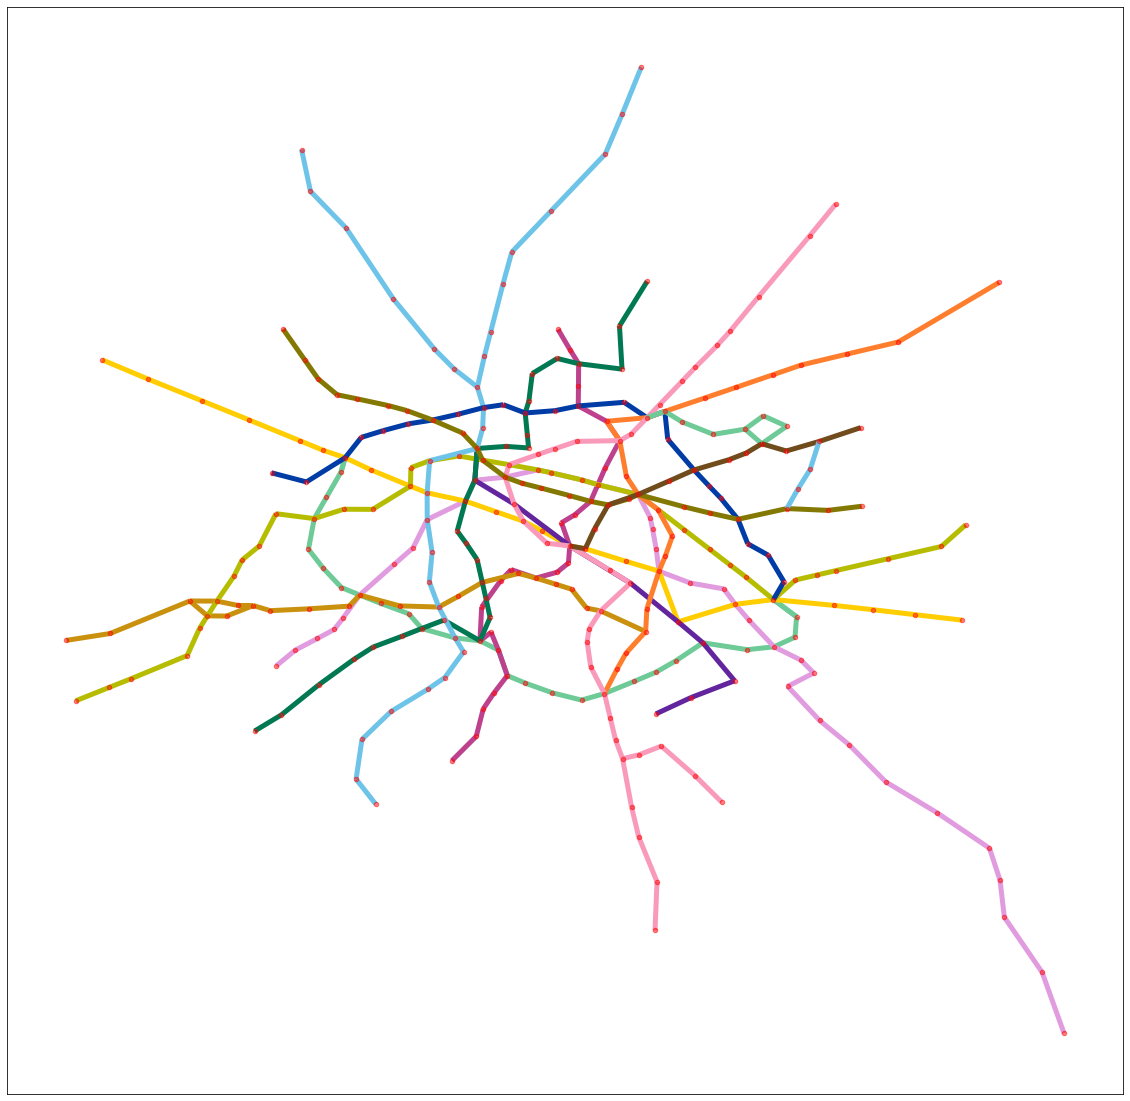

In [24]:
G = nx.Graph()
pos = id_to_xy


plt.figure(figsize=(20,20))
G.add_edges_from(links)
colors = { '1': '#ffcd00', '2': '#003ca6', '3': '#837902', '3b': '#6ec4e8', '4': '#be418d', '5': '#ff7e2e', '6': '#6eca97', '7': '#fa9aba', '7b': '#6eca97', '8': '#e19bdf', '9': '#b6bd00', '10': '#c9910d', '11': '#704b1c', '12': '#007852', '13': '#6ec4e8', '14': '#62259d', '15': '#a81032', '16': '#e170a7', '17': '#96c047', '18': '#147a88'}
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='red',alpha=0.5)

for index, links in line_to_links.items():
    nx.draw_networkx_edges(G,pos,edgelist=links,edge_color=colors[index], width=5)
    
plt.show()

## V. Another representation of the graph

In a paper<sup>[1](#ref1)</sup> by Marc Barthélemy, we saw that spatial networks can be represented in another way : nodes will represent the lines of Metros, and the edges show the connection between the lines. As a result, if two lines have a common station, they are going to have a connection in the new graph.<br>

We are going to create this line correspondance graph. It will contain new metrics that could help to explain the station graph.

> Two different station graphs would produce two different correspondance graphs. As a result, our analysis of our correspondance graph will be an analysis of the station graph, not an analysis of the transformation operation. The proof of this fact requires further developpement int the future. 



<b>lines_labels</b> list is saving the nodes (metro lines)<br>
<b>lines_links</b> dictionary shows the connection between the nodes<br>
There are 14 Metro lines, specifying also the number of nodes there are on this graph.

In [25]:
lines_labels = set()
lines_links = []
link_to_label = {}
new_lines_links = []

with open('./data/Projet/gares-et-stations-du-reseau-ferre-dile-de-france-donnee-generalisee.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=';', quotechar='"')
    for row in reader:
        # Filters on Metro lines
        if 'Metro' not in row['mode_']:
            continue

        line_correspondences = row['res_com'].split(" / ")
        line_correspondences = [line for line in line_correspondences if line[0] == 'M']

        for line_label in line_correspondences:
            lines_labels.add(line_label)

        for i, line_1 in enumerate(line_correspondences):
            for line_2 in line_correspondences[i+1:]:
                lines_links.append((line_1, line_2))
                link_to_label[(line_1, line_2)] = row['nom_long']
        
for lines_link in lines_links:
    line_1 = lines_link[0].replace('M7bis', 'M7').replace('M3bis', 'M3').replace('M7b', 'M7')
    line_2 = lines_link[1].replace('M7bis', 'M7').replace('M3bis', 'M3').replace('M7b', 'M7')
    if line_1 != line_2 :
        new_lines_links.append((line_1, line_2))
        
lines_labels.remove('M7b')
lines_labels.remove('M7bis')
lines_labels.remove('M3bis')
print(f"Metro Lines(nodes): \n{lines_labels}")
print(f"\nMetro links :\n[{new_lines_links[0:3].__str__()[1:-1]} ...]")

Metro Lines(nodes): 
{'M1', 'M3', 'M4', 'M10', 'M13', 'M7', 'M12', 'M2', 'M5', 'M14', 'M9', 'M11', 'M8', 'M6'}

Metro links :
[('M1', 'M13'), ('M2', 'M4'), ('M4', 'M10') ...]


Number of nodes and edges:

In [26]:
print(f"Number of nodes : {len(lines_labels)}")
print(f"Number of edges : {len(lines_links)}")

Number of nodes : 14
Number of edges : 112


Create a new Graph based on nodes that represent the metro lines and egdes that represent the connection between them.

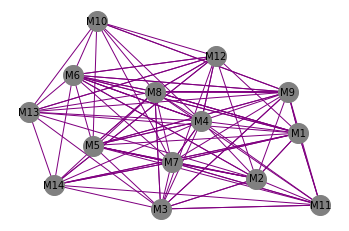

In [27]:
new_G = nx.Graph()
new_G.add_edges_from(new_lines_links)
position = nx.spring_layout(new_G)

nx.draw_networkx_nodes(new_G, position, node_size=400, node_color='grey')
nx.draw_networkx_labels(new_G, position, font_size=10, font_family='sans-serif')
nx.draw_networkx_edges(new_G, position, edgelist=new_lines_links, edge_color='purple')
plt.axis('off')
plt.show()

The further analysis is based on the communication between metro lines. The <b>diameter</b> is strictly smaller, just as the **average_shortest_path_length**.<br>

Intuitively, we expect that the clustering coefficient would be higher in the correspondance graph than the station graph's because :

- certain nodes of our first graph have a high degree
- on these nodes, the transformation will contain as many stations as the degree
- those stations will be fully connected with a clustering = 1
- the nodes with a degree = 1 or 2 will not participate in the construction of the correspondance graph (except the 2 degree nodes who are at the end of a line).

In [28]:
diameter = nx.diameter(new_G)
print(f"Le diamètre du graph est : {diameter}")

Le diamètre du graph est : 2


The diameter of the graph is very low.

This metrics is really important to understand how the metro was built :

<b>In a metro network each line is rapidly accessible from another one</b> without going through many correspondence.

Another way to express that : we don't mind that a lot of stations separate us from the one we want to reach if we can stay on the same line.

In [29]:
print(f"Average Shorterst Path: {nx.average_shortest_path_length(new_G)}")

Average Shorterst Path: 1.2087912087912087


In [30]:
nx.average_clustering(new_G)

0.7899033506176363

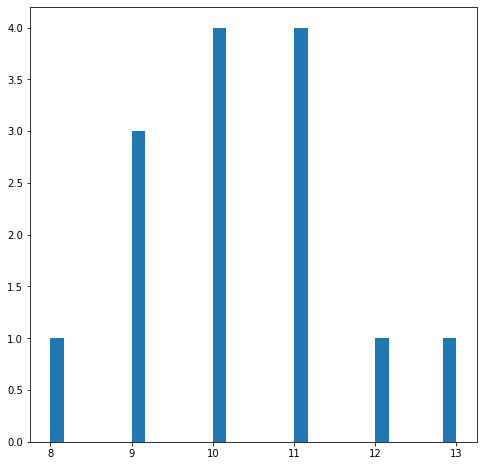

In [31]:
degree_sequence = [d for n, d in new_G.degree()]
plt.figure(figsize=(8,8))
plt.hist(degree_sequence, 30);

The degree of each node is high. There is no node with a degree < 8. It means that each line have a correspondance with 8 other lines.

One line has 13 correspondance so it has a correspondance with every other lines.

This explains that the graph have a diameter = 2.

Another consequence is the graph is very dense.

<div style="border:3px solid #41a4f5; margin:10px; padding:10px">
<h3 id="Summary-of-the-second">Summary of the second analysis<a class="anchor-link" href="#Résumé-de-l'analyse">¶</a></h3>
The metro correspondance graph :
  <ul>
<li><input checked="" disabled="" type="checkbox"> is connected</li>
<li><input disabled="" type="checkbox"> is not sparse</li>
<li><input checked="" disabled="" type="checkbox"> is small world</li>
<li><input checked="" disabled="" type="checkbox"> don't have a heterogeneous degree distribution</li>
<li><input checked="" disabled="" type="checkbox"> has a high average clustering coefficient</li>
</ul>

</div>

<div style="border-bottom: 3px dashed #41a4f5; margin:10px;"></div>

## VI.  Centrality analysis

In [32]:
from bokeh.plotting import figure, show
from bokeh.resources import CDN
from bokeh.io import output_notebook
import colorsys
from math import log
from bokeh.models import Legend, LegendItem
from bokeh.models import LogColorMapper, LogTicker, ColorBar
output_notebook( resources=CDN )

Loading BokehJS ...

We are able to represent the nodes based on the traffic of each station. The spectrum goes from green to red, from lowest to highest number of visitors for station. The size of the node also reflects the change. <br>
The two most important stations are in red, going down to the orange dots, until we are finished with the green nodes.

In [33]:
def pseudocolor(val):
    h = (1.0 - val) * 120 / 360
    r, g, b = colorsys.hsv_to_rgb(h, 1., 1.)
    return int(r * 255), int(g * 255), int(b * 255)

In [54]:
p = figure(
    x_range = (2.2,2.5),
    y_range = (48.767,48.95),
    height= 700,
    width= 900,
)
min_x = 10000000000000
max_x = -1
min_y = 10000000000000
max_y = -1
for edge in G.edges():
    p.line( 
        x= [id_to_xy[pt][0] for pt in edge],
        y= [id_to_xy[pt][1] for pt in edge],
    )
    
min_traffic = id_to_traffic[min(id_to_traffic, key=id_to_traffic.get)]
max_traffic = id_to_traffic[max(id_to_traffic, key=id_to_traffic.get)]
for node in G.nodes():
    if node not in id_to_traffic:
        #print(id_to_label[node])
        continue
    x = [id_to_xy[node][0]]
    y = [id_to_xy[node][1]]
    t = float(id_to_traffic[node])
    radius = .00000000025 * t
    if x[0] > max_x:
        max_x = x[0]
    if x[0] < min_x:
        min_x = x[0]
    if y[0] > max_y:
        max_y = y[0]
    if y[0] < min_y:
        min_y = y[0]
    color = pseudocolor(t/max_traffic)
    p.circle(
        x, y, 
        radius = radius, 
        fill_color = color, 
        line_alpha=0)

colors = range(1000)
#colors = [pseudocolor(c/1000) for c in colors]
colors = ['#%02x%02x%02x' % pseudocolor(c/1000) for c in colors]
#print(colors)
print(max_traffic)
color_mapper = LogColorMapper(palette=colors, low=min_traffic, high=max_traffic)
color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p.add_layout(color_bar, 'right')

50793797.0


In [55]:
show(p)

### Centrality

The size of the nodes reflect the trafic on the respective station. <br>
The question is: <br><b>Can we say that the higher the traffic, the higher the centrality of the station?</b><br>
If we look at the data given, they do not provide us with information that prove this hypothesis right. The colors go from green to red, representing the centrality of the node.<br>
Actually, one of the biggest node in the whole graph has a green color, which means that its centrality is low. And relatively stations with lower traffic have a red color on them. <br>
<br>
First, we are going to take a look at the graph, based on the degree of the centrality. The focus is on the stations with the highest degree and the question that we have, gets transformed into:
"Do the stations with the highest traffic, have the highest degree?" In other words: <br><b>Do the most important stations (as far as correspondance goes), have a high degree centrality?</b><br><br>


In [36]:
id_to_centrality = nx.degree_centrality(G)

In [50]:
p2 = figure(
    x_range = (2.2,2.5),
    y_range = (48.767,48.95),
    height= 700,
    width= 900,
)

for edge in G.edges():
    p2.line( 
        x= [id_to_xy[pt][0] for pt in edge],
        y= [id_to_xy[pt][1] for pt in edge],
    )
    
min_centrality = id_to_centrality[min(id_to_centrality, key=id_to_centrality.get)]
max_centrality = id_to_centrality[max(id_to_centrality, key=id_to_centrality.get)]
print((max_x-min_x))
for node in G.nodes():
    if node not in id_to_traffic:
        #print(id_to_label[node])
        continue
    x = [id_to_xy[node][0]]
    y = [id_to_xy[node][1]]
    t = float(id_to_centrality[node])
    radius = .00000000025 * id_to_traffic[node]
    color = pseudocolor(t/max_centrality)
    p2.circle(
        x, y, 
        radius = radius, 
        fill_color = color, 
        line_alpha=0)
    
colors = range(1000)
#colors = [pseudocolor(c/1000) for c in colors]
colors = ['#%02x%02x%02x' % pseudocolor(c/1000) for c in colors]
#print(colors)
#print(max_traffic)
color_mapper = LogColorMapper(palette=colors, low=min_centrality, high=max_centrality)
color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p2.add_layout(color_bar, 'right')

0.23602801170638088


In [51]:
show(p2)

We can clearly tell that this hypothesis is proven wrong, meaning that <b> a station cannot necessarily have high centrality and a high traffic number.</b> <br> The size of the node, represents the traffic of the station during a survey done in 2015, and the color represents the centrality.<br>We can see that the color red (which represents the highest centrality) does not necessarily correspond to the larger nodes (and vice-versa).

Another way to prove the hypothesis wrong, is to check the betwenness. So the question transforms once more:
<br><b>Do the most important stations (as far as correspondance goes), have a high betweenness centrality?</b>
<br>We can look at the most important nodes of the graph, and check if they are indeed if their size corresponds to its color: bigger nodes should me closer to red and smaller ones closer to green.

In [39]:
id_to_betweenness = nx.betweenness_centrality(G)

In [68]:
p3 = figure(
    x_range = (2.2,2.5),
    y_range = (48.767,48.95),
    height= 700,
    width= 900,
)

for edge in G.edges():
    p3.line( 
        x= [id_to_xy[pt][0] for pt in edge],
        y= [id_to_xy[pt][1] for pt in edge],
    )
    
min_betweenness = id_to_betweenness[min(id_to_betweenness, key=id_to_betweenness.get)]
max_betweenness = id_to_betweenness[max(id_to_betweenness, key=id_to_betweenness.get)]
print((max_x-min_x))
for node in G.nodes():
    if node not in id_to_traffic:
        #print(id_to_label[node])
        continue
    x = [id_to_xy[node][0]]
    y = [id_to_xy[node][1]]
    t = float(id_to_betweenness[node])
    radius = .00000000025 * id_to_traffic[node]
    color = pseudocolor(t/max_betweenness)
    p3.circle(
        x, y, 
        radius = radius, 
        fill_color = color, 
        line_alpha=0)
colors = range(1000)
#colors = [pseudocolor(c/1000) for c in colors]
colors = ['#%02x%02x%02x' % pseudocolor(c/1000) for c in colors]
#print(colors)
#print(max_traffic)
color_mapper = LogColorMapper(palette=colors, low=min_betweenness, high=max_betweenness)
color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p3.add_layout(color_bar, 'right')

0.23602801170638088


In [69]:
show(p3)

For the second time, we proved that the centrality does not correspond to the traffic of the station. <br>
The stations with the highest betweenness coefficient are not that many in number whatsoever (in comparison to station with high number of traffic).

## VII. Conclusions

A metro network based graph can be represented in two points of views: either taking stations as nodes and the connection between them as edges OR seeing the metro lines as the nodes and the correspondance stations as edges.<br> 
The first point of view, is not a complex graph, because he is not a small world and it has a low clustering coefficient. <br> The second representation, shows a graph only focused on the connection stations, neglecting all the edges that belong to only one metro line, making the new graph be a complex one, meaning the clustering coefficient is actually high and the graph is a small world. You can clearly see the differences in other details between the two of them, such as the degree and diameter, which are smaller on the first graph and higher on the second one.<br><br> The question that we had, was to know if the actual traffic number has any weight with the centrality of the graph. The hypothesis was: the highiest the traffic, the highest the centrality degree for that node. <br> 
This Hypothesis was proven wrong when in the graph showen, the colors did not correspond to to size of the nodes whatsoever. Bigger nodes has the lowest centrality and vice versa. 

### References

+ <sup>1</sup> <a name="ref1" href="https://arxiv.org/pdf/1010.0302.pdf"></a>[Marc Barthélemy - Spatial Networks. ArXiv, 2010.]
+ <sup>2</sup> <a name="ref2" href="http://markdunne.github.io/2016/04/10/The-London-Tube-as-a-Graph/">Mark Dunne - The-London-Tube-as-a-Graph</a>



## SPECIFICATIONS

The data that are provided in this document are not 100% cooperative with each other. Some of the train station's names did not match from document to document, having some minimal differences with between each other.
Some of the information was fixed by hand. There are still 5 stations that are not shown in the graph as a result of not being in the other documents.